In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
loan_data_file = pd.read_csv("loan_data_2007_2014.csv", header = 0, index_col = 0)

In [4]:
# create a new column based on the loan_status column that will be our target variable
loan_data_file['good_bad'] = np.where(loan_data_file.loc[:, 'loan_status'].isin(['Charged Off', 'Default',
                                                                       'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)

In [5]:
# drop columns with more than 80% null values
loan_data_file.dropna(thresh = loan_data_file.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

In [6]:
loan_data_file.drop(columns =['member_id', 'emp_title', 'pymnt_plan', 'url', 'desc', 
                         'title','zip_code', 'next_pymnt_d', 'recoveries', 'collection_recovery_fee','addr_state', 'mths_since_last_delinq', 
                         'next_pymnt_d', 'tot_coll_amt', 'tot_cur_bal', 'mths_since_last_major_derog'], axis = 1, inplace = True)

In [7]:
# Drop the original 'loan_status' column
loan_data_file.drop(columns = ['loan_status'], inplace = True)

In [9]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = loan_data_file.drop('good_bad', axis = 1)
y = loan_data_file['good_bad']

# splitting into test and train after treating variables
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,stratify = y, #to keep class balance during splitting,
                                             random_state=42)

In [10]:
# function to clean up the emp_length column, assign 0 to NANs, and convert to numeric
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

In [11]:
emp_length_converter(X_train,'emp_length')
emp_length_converter(X_test,'emp_length')

In [12]:
'''
function to convert date columns to datetime format and
create a new column as a difference between today and the respective date
'''
def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / 
							np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(
		lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

In [13]:
# apply to df
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')

In [14]:
# function to remove 'months' string from the 'term' column and convert it to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

In [15]:
loan_term_converter(X_train,'term')
loan_term_converter(X_test,'term')

In [16]:
#train = pd.concat([y_train, X_train], axis=1)
#test = pd.concat([y_test, X_test], axis=1)
#train.to_csv('TrainData.csv',index=False)
#test.to_csv('TestData.csv',index=False)

## Checking categorical features

In [17]:
!pip install OptBinning

#### Optbinning needs the information whether the features are numerical or categorical. So we are going to verify the dtypes of each column to make sure it's correct.

In [18]:
X_train.dtypes.value_counts()

float64    27
object      7
int64       5
dtype: int64

In [19]:
X_train.select_dtypes(include='object')

,grade,sub_grade,home_ownership,verification_status,purpose,initial_list_status,application_type
id,,,,,,,
10588532,A,A5,MORTGAGE,Source Verified,credit_card,w,INDIVIDUAL
11215587,D,D3,OWN,Verified,other,f,INDIVIDUAL
14218271,D,D4,OWN,Source Verified,credit_card,f,INDIVIDUAL
6504869,A,A1,MORTGAGE,Not Verified,debt_consolidation,w,INDIVIDUAL
3929378,B,B3,MORTGAGE,Verified,debt_consolidation,f,INDIVIDUAL
...,...,...,...,...,...,...,...
3368168,C,C4,MORTGAGE,Verified,debt_consolidation,f,INDIVIDUAL
15440103,B,B4,MORTGAGE,Verified,credit_card,w,INDIVIDUAL
9025241,C,C1,MORTGAGE,Verified,debt_consolidation,f,INDIVIDUAL


## Creating the BinningProcess instance

In [47]:
from optbinning import Scorecard, BinningProcess
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier

#metrics
from optbinning.scorecard import plot_auc_roc,plot_cap, plot_ks
from sklearn.metrics import mean_squared_error, r2_score,classification_report, auc, roc_curve

The Scorecard need an instance of BinningProcess with the corresponding data for the dataset and also an sklearn.linear_model.
We can also provide a selection_criteria for the selection of features.

In [22]:
list_features = X_train.columns.values
list_categorical = X_train.select_dtypes(include=['object', 'category']).columns.values
selection_criteria = {"iv": {"min": 0.005, 'max':0.5, "strategy": "highest"}}

In [23]:
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_features,
    selection_criteria=selection_criteria,
)

## Defining the Linear Estimator

Scorecard accepts any Linear Estimator from Scikit-Learn.

In [24]:
logreg = LogisticRegression(C=3, max_iter=1000, random_state=161, class_weight = 'balanced')

In [25]:
lr = Pipeline(steps=[('binning_process', binning_process),
                     ('regressor', logreg)])

In [26]:
lr.fit(X_train, y_train)

Pipeline(steps=[('binning_process',
                 BinningProcess(categorical_variables=array(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose', 'initial_list_status', 'application_type'], dtype=object),
                                selection_criteria={'iv': {'max': 0.5,
                                                           'min': 0.005,
                                                           'strategy': 'highest'}},
                                variable_names=array(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'i...
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'application_type', 'acc_now_delinq', 'total_rev_hi_lim',
       'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d'],
      dtype=object))),
                ('regressor',
                 LogisticRegression(C=

In [27]:
y_test_predict = lr.predict(X_test)

print("MSE:      {:.3f}".format(mean_squared_error(y_test, y_test_predict)))
print("R2 score: {:.3f}".format(r2_score(y_test, y_test_predict)))

MSE:      0.325
R2 score: -2.342


In [38]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.20      0.67      0.31     10194
           1       0.94      0.68      0.79     83063

    accuracy                           0.67     93257
   macro avg       0.57      0.67      0.55     93257
weighted avg       0.86      0.67      0.73     93257



In [48]:
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr1, tpr1, threshold = roc_curve(y_test, y_test_predict)
roc_auc1 = auc(fpr1, tpr1)

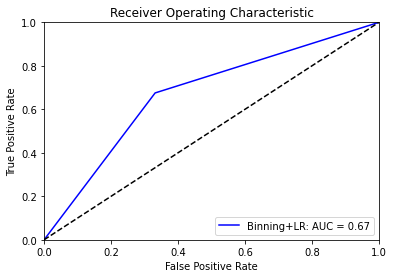

In [49]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='Binning+LR: AUC = {0:.2f}'.format(roc_auc1))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Creating a Scorecard
To instantiate the Scorecard class you need to pass as parameters the binning_process and linear model (log_reg),

In [24]:
X_train.shape

(373028, 39)

In [25]:
scaling_method = "min_max"
scaling_method_data = {"min": 0, "max": 1000}
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=False,
    reverse_scorecard=True,
)
scorecard.fit(X_train,y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=array(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose', 'initial_list_status', 'application_type'], dtype=object),
                                         selection_criteria={'iv': {'max': 0.5,
                                                                    'min': 0.005,
                                                                    'strategy': 'highest'}},
                                         variable_names=array(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',...
       'application_type', 'acc_now_delinq', 'total_rev_hi_lim',
       'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d'],
      dtype=object)),
          estimator=LogisticRegression(C=3, class_weight='balanced',
                                       max_iter=1000, random_state=161),
          reverse_scorecard=True, scaling_met

### Visualizing Scorecard

In [26]:
scorecard_summary = scorecard.table(style="detailed").round(3)
scorecard_summary.to_csv('scorecard_table_detailed.csv', index=False)
scorecard_summary

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,term,0,"(-inf, 48.00)",270199,0.724,26145,244054,0.903,-0.136,0.013,0.002,-0.385,31.961
1,term,1,"[48.00, inf)",102829,0.276,14629,88200,0.858,0.301,0.028,0.004,-0.385,12.193
2,term,2,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.385,25.816
3,term,3,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.385,25.816
0,int_rate,0,"(-inf, 7.50)",23548,0.063,595,22953,0.975,-1.555,0.085,0.010,-0.628,140.405
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,mths_since_last_credit_pull_d,2,"[59.50, 64.50)",24875,0.067,3961,20914,0.841,0.434,0.015,0.002,-0.743,-12.033
3,mths_since_last_credit_pull_d,3,"[64.50, 73.50)",27481,0.074,6091,21390,0.778,0.842,0.072,0.009,-0.743,-47.603
4,mths_since_last_credit_pull_d,4,"[73.50, inf)",27729,0.074,6484,21245,0.766,0.911,0.087,0.010,-0.743,-53.650
5,mths_since_last_credit_pull_d,5,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.743,25.816


## Visualizing Scorecard performance

In [27]:
X_test.loc[:,"predict_proba"] = scorecard.predict_proba(X_test)[:, 1]
X_test.loc[:,"score"] = scorecard.score(X_test)

In [29]:
plot_ks(y_test, X_test.score, savefig=True, fname='scorecard_ks_plot.jpeg', dpi=100)

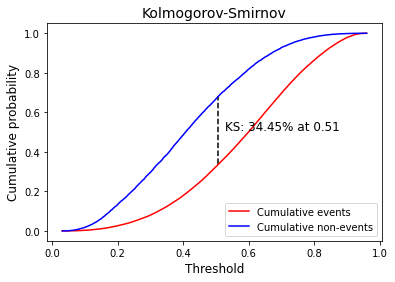

In [30]:
plot_ks(y_test, X_test.predict_proba)

## Interpret the ROC curve
The ROC (Receiver Operating Characteristics) curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. AUC (Area Under The Curve) represents the degree or measure of separability. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1

In [31]:
# ROC-AUC plot
plot_auc_roc(y_test, X_test.score, savefig=True, fname='scorecard_rocauc_plot.jpeg', dpi=100)

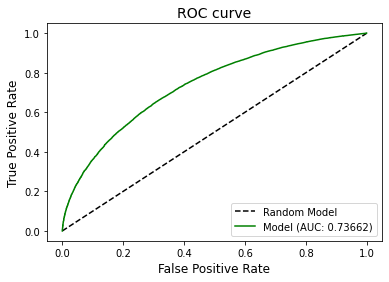

In [32]:
plot_auc_roc(y_test, X_test.predict_proba)

## Saving the Scorecard as pickle and using it for prediction

Scorecard objects can easily be pickled and saved for further usage or put into production.

## Pickling Scorecard

In [33]:
import pickle

with open('scorecard_model.pickle', 'wb') as pfile:
   pickle.dump(scorecard, pfile)

## Unpickling Scorecard

In [34]:
with open("scorecard_model.pickle", 'rb') as scorecard_pickle:
    scorecard_production = pickle.load(scorecard_pickle)
print(scorecard_production)

Scorecard(binning_process=BinningProcess(categorical_variables=array(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose', 'initial_list_status', 'application_type'], dtype=object),
                                         selection_criteria={'iv': {'max': 0.5,
                                                                    'min': 0.005,
                                                                    'strategy': 'highest'}},
                                         variable_names=array(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',...
       'application_type', 'acc_now_delinq', 'total_rev_hi_lim',
       'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d'],
      dtype=object)),
          estimator=LogisticRegression(C=3, class_weight='balanced',
                                       max_iter=1000, random_state=161),
          reverse_scorecard=True, scaling_met

## Performing predictions in production

In [35]:
# For one sample
scorecard_production.score(X_test.iloc[0:1, :])

array([462.1689143])

In [36]:
# For a few samples
scorecard_production.score(X_test.iloc[0:3, :])

array([462.1689143 , 755.20507852, 573.67267116])